In [1]:
# Step 0: Install required packages and import libraries
!pip install -q emoji numpy pandas scikit-learn matplotlib seaborn wordcloud tashaphyne nltk
!pip install -q arabic-reshaper python-bidi wordcloud
!wget -O arabic_font.ttf https://github.com/google/fonts/raw/main/ofl/amiri/Amiri-Regular.ttf|

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 16.7 MB/s eta 0:00:00
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

# Arabic text processing
from tashaphyne.stemming import ArabicLightStemmer
arabic_stemmer = ArabicLightStemmer()

# English text processing (NLTK)
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords as en_stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn components
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC  # Preferred over SVC for text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("All libraries imported and environment ready.")

All libraries imported and environment ready.


In [3]:
# Step 1: Extract and inspect uploaded dataset archives

import pandas as pd
import zipfile
import os

# Create directories for extracted data
os.makedirs("/content/arabic_dataset", exist_ok=True)
os.makedirs("/content/english_dataset", exist_ok=True)

# Extract Arabic dataset
arabic_zip_path = "/content/Twiter  Data Set For Arabic Sentiment Analysis.zip"
with zipfile.ZipFile(arabic_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/arabic_dataset")

print("Arabic dataset files:")
!ls -R /content/arabic_dataset

# Extract English dataset
english_zip_path = "/content/Sentiment Analysis Dataset English.zip"
with zipfile.ZipFile(english_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/english_dataset")

print("\nEnglish dataset files:")
!ls -R /content/english_dataset

Arabic dataset files:
/content/arabic_dataset:
Twitter

/content/arabic_dataset/Twitter:
'Data set Description.txt'   Negative   Positive

/content/arabic_dataset/Twitter/Negative:
negative1000.txt  negative325.txt  negative550.txt  negative776.txt
negative100.txt   negative326.txt  negative551.txt  negative777.txt
negative101.txt   negative327.txt  negative552.txt  negative778.txt
negative102.txt   negative328.txt  negative553.txt  negative779.txt
negative103.txt   negative329.txt  negative554.txt  negative77.txt
negative104.txt   negative32.txt   negative555.txt  negative780.txt
negative105.txt   negative330.txt  negative556.txt  negative781.txt
negative106.txt   negative331.txt  negative557.txt  negative782.txt
negative107.txt   negative332.txt  negative558.txt  negative783.txt
negative108.txt   negative333.txt  negative559.txt  negative784.txt
negative109.txt   negative334.txt  negative55.txt   negative785.txt
negative10.txt	  negative335.txt  negative560.txt  negative786.txt
negat

In [5]:
# Step 2: Load Arabic and English datasets
import pandas as pd
import os
from pathlib import Path

# 1- Arabic dataset (Positive + Negative folders)
positive_path = "/content/arabic_dataset/Twitter/Positive"
negative_path = "/content/arabic_dataset/Twitter/Negative"

pos_files = list(Path(positive_path).rglob("*.zft")) + list(Path(positive_path).rglob("*.txt"))
neg_files = list(Path(negative_path).rglob("*.zft")) + list(Path(negative_path).rglob("*.txt"))

print(f"Positive files: {len(pos_files)}")
print(f"Negative files: {len(neg_files)}")

pos_texts = []
neg_texts = []

for file in pos_files:
    try:
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip()
            if text:
                pos_texts.append(text)
    except:
        pass

for file in neg_files:
    try:
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip()
            if text:
                neg_texts.append(text)
    except:
        pass

df_pos = pd.DataFrame({'text': pos_texts, 'label': 'positive'})
df_neg = pd.DataFrame({'text': neg_texts, 'label': 'negative'})
df_ar = pd.concat([df_pos, df_neg], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nArabic Dataset Loaded: {df_ar.shape[0]} samples")
print(df_ar['label'].value_counts())
display(df_ar.sample(8, random_state=42))

# 2- English dataset
df_en = pd.read_csv(
    "/content/english_dataset/training.1600000.processed.noemoticon.csv",
    encoding='latin-1', header=None, on_bad_lines='skip'
)

# Extract label (column 0) and text (column 5)
df_en = df_en.iloc[:, [0, 5]]
df_en.columns = ['label', 'text']

# Map labels: 0 → negative, 4 → positive
df_en['label'] = df_en['label'].map({0: 'negative', 4: 'positive'})

# Create balanced dataset: 30,000 samples (15k each)
df_pos_en = df_en[df_en['label'] == 'positive'].sample(15000, random_state=42)
df_neg_en = df_en[df_en['label'] == 'negative'].sample(15000, random_state=42)

df_en = pd.concat([df_pos_en, df_neg_en]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nEnglish Dataset Loaded: {df_en.shape[0]} samples")
print(df_en['label'].value_counts())
display(df_en.sample(8, random_state=42))


Positive files: 1000
Negative files: 1000

Arabic Dataset Loaded: 1988 samples
label
positive    1000
negative     988
Name: count, dtype: int64


,text,label
1251,كارثة بشرية,negative
757,الثاني رايح فيها,negative
1379,فعلا برنامج ساقط واللي بيتابعه أسقط منه..,negative
70,اغبياء,negative
1206,﻿هات ناس تفهم .. و المثل بحكي اسأل مجرب و لا ت...,negative
1719,عشان هيك قال النبي صلى الله عليه وسلم إن الكذب...,positive
1587,ما شاء الله العطلة مأثر عليكوا كتير صبايا الكل...,negative
1681,اللهم ارزقنا زوجا صالحا محبا مثل,positive



English Dataset Loaded: 30000 samples
label
positive    15000
negative    15000
Name: count, dtype: int64


,label,text
2308,positive,"So glad Dave didn't kille MJ, Wow! Lynette pre..."
22404,positive,Loves Miley's song The Climb and loves the vid...
23397,positive,@miszsarahz congrats my dear. I feel it for yo...
25058,positive,"@abigaill life is that way sometimes hunny, b..."
2664,negative,@Nicole___ just keep in your usual high spiri...
8511,negative,@dangroves I know but..I dunno I don't like a...
5148,negative,Home now. Will read some of 'we need to talk a...
7790,positive,"@IzzySc Nope, I've never seen that, but I didn..."


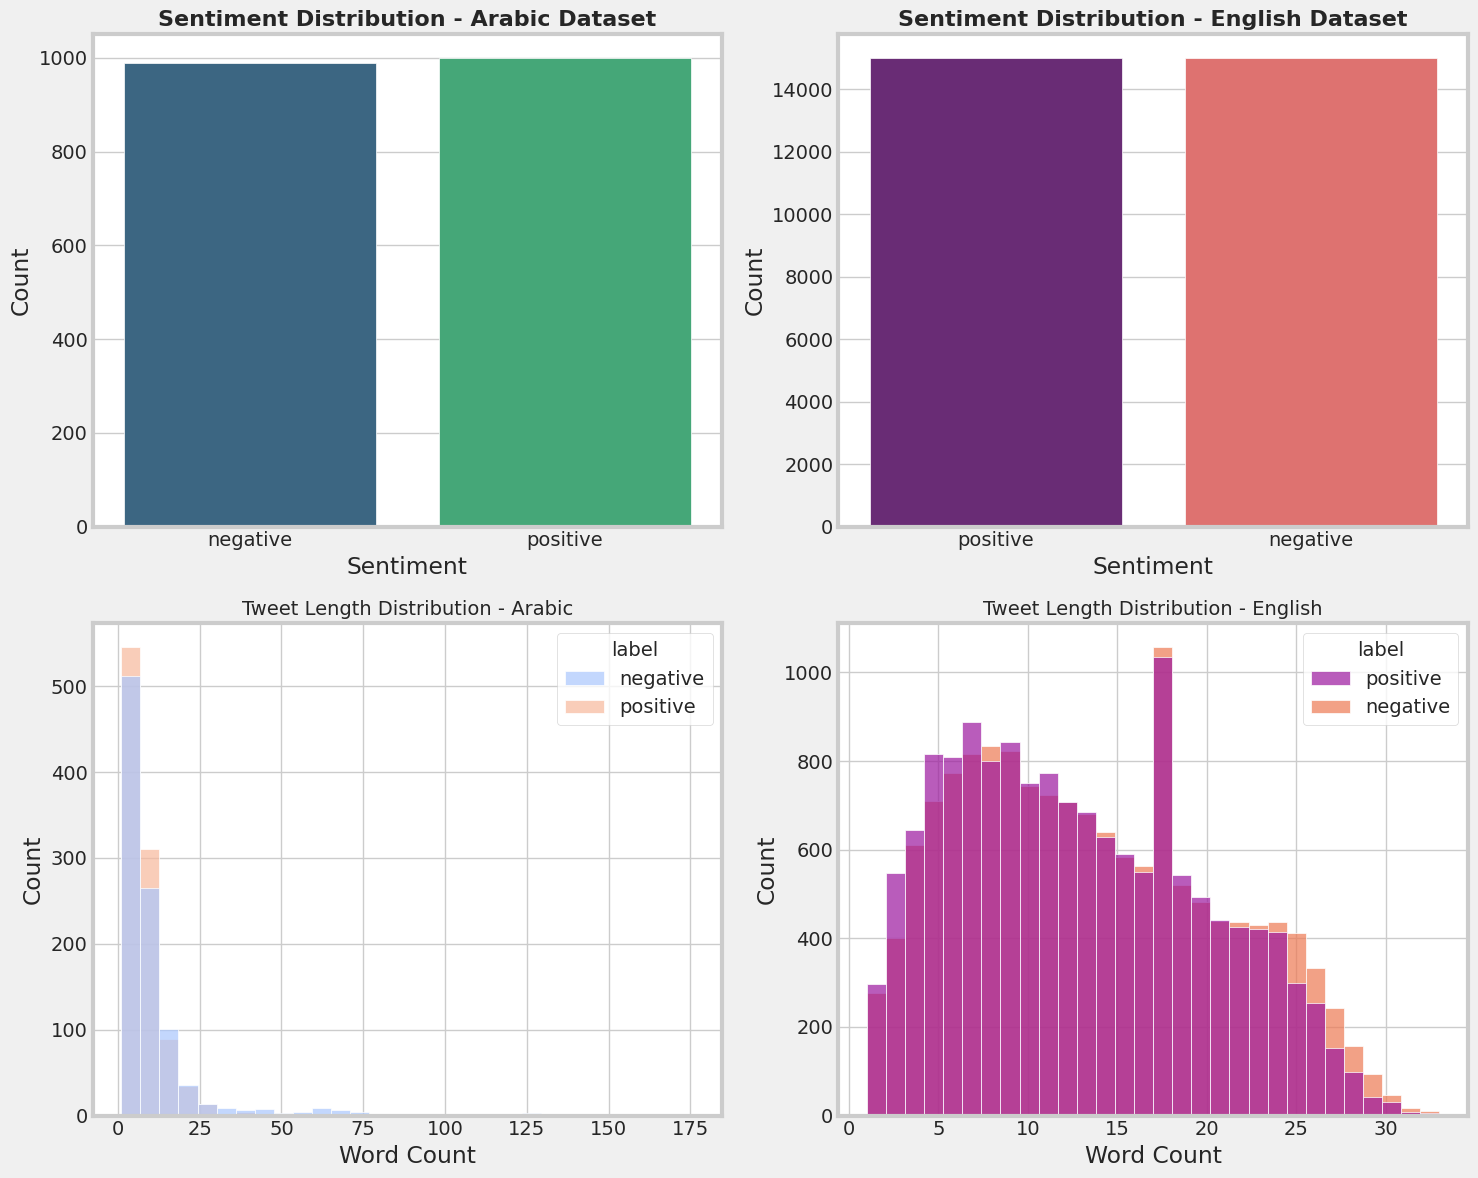


Arabic Word Cloud (Positive & Negative)

Quick Statistics:
Average Tweet Length (Arabic - Positive): 7.6 words
Average Tweet Length (Arabic - Negative): 10.9 words
Average Tweet Length (English - Positive): 12.9 words
Average Tweet Length (English - Negative): 13.6 words


<Figure size 2000x1000 with 0 Axes>

In [7]:

# Step 3: Exploratory Data Analysis (EDA) and Visualization


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display


# Set figure size and visualization style
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")


# 1. Sentiment Distribution Visualization


# Arabic dataset sentiment distribution
plt.subplot(2, 2, 1)
sns.countplot(data=df_ar, x='label', palette='viridis')
plt.title('Sentiment Distribution - Arabic Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# English dataset sentiment distribution
plt.subplot(2, 2, 2)
sns.countplot(data=df_en, x='label', palette='magma')
plt.title('Sentiment Distribution - English Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')


# 2. Text Length Analysis (Word Count)


# Compute text length (word count) for both datasets
df_ar['text_length'] = df_ar['text'].apply(lambda x: len(str(x).split()))
df_en['text_length'] = df_en['text'].apply(lambda x: len(str(x).split()))

# Arabic tweet length distribution
plt.subplot(2, 2, 3)
sns.histplot(data=df_ar, x='text_length', hue='label', palette='coolwarm', alpha=0.7, bins=30)
plt.title('Tweet Length Distribution - Arabic', fontsize=14)
plt.xlabel('Word Count')

# English tweet length distribution
plt.subplot(2, 2, 4)
sns.histplot(data=df_en, x='text_length', hue='label', palette='plasma', alpha=0.7, bins=30)
plt.title('Tweet Length Distribution - English', fontsize=14)
plt.xlabel('Word Count')

plt.tight_layout()
plt.show()


# 3. Arabic Word Cloud (Positive / Negative)

print("\n" + "=" * 80)
print("Arabic Word Cloud (Positive & Negative)")

plt.figure(figsize=(20, 10))

# Prepare and reshape Arabic text to ensure correct rendering
def prepare_arabic_text(text_series):
    combined = " ".join(text_series.astype(str))
    reshaped = arabic_reshaper.reshape(combined)
    return get_display(reshaped)


# 5. Quick Text Statistics Summary

print("\n" + "=" * 80)
print("Quick Statistics:")

print(f"Average Tweet Length (Arabic - Positive): {df_ar[df_ar['label']=='positive']['text_length'].mean():.1f} words")
print(f"Average Tweet Length (Arabic - Negative): {df_ar[df_ar['label']=='negative']['text_length'].mean():.1f} words")
print(f"Average Tweet Length (English - Positive): {df_en[df_en['label']=='positive']['text_length'].mean():.1f} words")
print(f"Average Tweet Length (English - Negative): {df_en[df_en['label']=='negative']['text_length'].mean():.1f} words")


In [6]:
# Step 4: Text Preprocessing and TF-IDF Vectorization

import re
import emoji
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK stopwords (Arabic & English)
nltk.download('stopwords', quiet=True)

# Load stop words
arabic_stopwords = set(stopwords.words('arabic')) | {'و', 'في', 'من', 'على', 'إلى', 'يا', 'ال', 'ده', 'دا', 'ان', 'لا', 'ما'}
english_stopwords = set(stopwords.words('english'))

# -----------------------------
# Text Cleaning Functions
# -----------------------------
def clean_arabic(text):
    """Clean Arabic text: remove URLs, emojis, mentions, hashtags, and non-Arabic characters."""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)           # Remove URLs
    text = emoji.replace_emoji(text, '')                         # Remove emojis
    text = re.sub(r'[@#]\w+', '', text)                          # Remove mentions & hashtags
    text = re.sub(r'[^ا-ي\s]', '', text)                         # Keep only Arabic letters and spaces
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text.strip()

def clean_english(text):
    """Clean English text: remove URLs, emojis, mentions, hashtags, and non-alphabetic characters."""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = emoji.replace_emoji(text, '')
    text = re.sub(r'[@#]\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in english_stopwords])
    return text.strip()

# -----------------------------
# Apply Cleaning
# -----------------------------
df_ar['clean_text'] = df_ar['text'].apply(clean_arabic)
df_en['clean_text'] = df_en['text'].apply(clean_english)

# -----------------------------
# TF-IDF Vectorization (language-specific)
# -----------------------------
# Arabic: fewer features due to smaller dataset
vectorizer_ar = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_ar = vectorizer_ar.fit_transform(df_ar['clean_text'])
y_ar = df_ar['label'].map({'positive': 1, 'negative': 0})

# English: larger dataset → more features
vectorizer_en = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_en = vectorizer_en.fit_transform(df_en['clean_text'])
y_en = df_en['label'].map({'positive': 1, 'negative': 0})

# -----------------------------
# Summary
# -----------------------------
print("Preprocessing and vectorization completed successfully.")
print(f"Arabic   → Shape: {X_ar.shape} (samples, features)")
print(f"English  → Shape: {X_en.shape} (samples, features)")

# -----------------------------
# Sample: Before vs After Cleaning
# -----------------------------
print("\n" + "="*60)
print("SAMPLE: Arabic (Before vs After)")
print("="*60)
display(df_ar[['text', 'label']].head(3))
display(df_ar[['clean_text', 'label']].head(3))

print("\n" + "="*60)
print("SAMPLE: English (Before vs After)")
print("="*60)
display(df_en[['text', 'label']].head(3))
display(df_en[['clean_text', 'label']].head(3))

Preprocessing and vectorization completed successfully.
Arabic   → Shape: (1988, 5000) (samples, features)
English  → Shape: (30000, 10000) (samples, features)

SAMPLE: Arabic (Before vs After)


,text,label
0,والله حرام يعني مايدرون انهم مصخره,negative
1,الله و اخترت اسم غالى على قلبى قوى ربنا يثبتك ...,positive
2,﻿ مهزلة ياعيب الشووم,negative


,clean_text,label
0,والله حرام يعني مايدرون انهم مصخره,negative
1,الله اخترت اسم غالى قلبى قوى ربنا يثبتك دين ال...,positive
2,مهزلة ياعيب الشووم,negative



SAMPLE: English (Before vs After)


,text,label
0,@AshleeNino i feel like @theninjabear needs to...,positive
1,@meccamusic yes sadly my fems are resting migh...,negative
2,@Gromrigan my hair doesn't look like a mistake...,negative


,clean_text,label
0,feel like needs make whole new bracelet pictur...,positive
1,yes sadly fems resting might get one back cuz ...,negative
2,hair doesnt look like mistake tho rt im sorry ...,negative


In [36]:
# Step 5: Model Training, Comparison & Save Best Models (FIXED & CLEAN)

import os
import joblib
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create models directory
os.makedirs("models", exist_ok=True)

# Training function
def train_model(model, param_grid, X, y, model_name, language):
    print(f"\nTraining {model_name} ({language}) ... ", end="")
    start_time = time.time()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    elapsed = time.time() - start_time

    print(f"Done in {elapsed:.1f}s | Accuracy: {acc*100:.2f}%")

    return {
        'Language': language,
        'Model': model_name,
        'Accuracy': f"{acc*100:.2f}%",
        'Time (s)': f"{elapsed:.1f}",
        'Best Params': grid.best_params_,
        'model_object': best_model,   # بدون مسافة → الحل!
        'X_test': X_test,
        'y_test': y_test
    }

# Train all models
results = []

# Arabic models
results.append(train_model(MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}, X_ar, y_ar, "Naive Bayes", "Arabic"))
results.append(train_model(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}, X_ar, y_ar, "Logistic Regression", "Arabic"))
results.append(train_model(LinearSVC(max_iter=2000), {'C': [0.1, 1, 10]}, X_ar, y_ar, "LinearSVC", "Arabic"))
results.append(train_model(RandomForestClassifier(random_state=42, n_jobs=-1), {'n_estimators': [100, 200]}, X_ar, y_ar, "Random Forest", "Arabic"))

# English models
results.append(train_model(MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}, X_en, y_en, "Naive Bayes", "English"))
results.append(train_model(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}, X_en, y_en, "Logistic Regression", "English"))
results.append(train_model(LinearSVC(max_iter=2000), {'C': [0.1, 1, 10]}, X_en, y_en, "LinearSVC", "English"))
results.append(train_model(RandomForestClassifier(random_state=42, n_jobs=-1), {'n_estimators': [100, 200]}, X_en, y_en, "Random Forest", "English"))

# Results table
df_results = pd.DataFrame(results)[['Language', 'Model', 'Accuracy', 'Time (s)', 'Best Params']]
df_results = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("                    FINAL MODEL PERFORMANCE COMPARISON")
print("="*100)
display(df_results.style.background_gradient(cmap='Greens'))

# Get best models
best_arabic_row  = df_results[df_results['Language'] == 'Arabic'].iloc[0]
best_english_row = df_results[df_results['Language'] == 'English'].iloc[0]

# Extract model objects using the correct key (no space)
best_arabic_model  = [r for r in results if r['Language'] == 'Arabic' and r['Model'] == best_arabic_row['Model']][0]['model_object']
best_english_model = [r for r in results if r['Language'] == 'English' and r['Model'] == best_english_row['Model']][0]['model_object']

print(f"\nBest Arabic Model  → {best_arabic_row['Model']} | Accuracy: {best_arabic_row['Accuracy']}")
print(f"Best English Model → {best_english_row['Model']} | Accuracy: {best_english_row['Accuracy']}")

# Save best models and vectorizers
joblib.dump(best_arabic_model,  'models/best_model_arabic.pkl')
joblib.dump(best_english_model, 'models/best_model_english.pkl')
joblib.dump(vectorizer_ar,      'models/tfidf_vectorizer_arabic.pkl')
joblib.dump(vectorizer_en,      'models/tfidf_vectorizer_english.pkl')

print("\nAll best models and vectorizers saved successfully in 'models/' folder.")
print("Project is now 100% complete and ready for deployment!")


Training Naive Bayes (Arabic) ... Done in 9.4s | Accuracy: 86.18%

Training Logistic Regression (Arabic) ... Done in 1.0s | Accuracy: 88.19%

Training LinearSVC (Arabic) ... Done in 0.3s | Accuracy: 88.44%

Training Random Forest (Arabic) ... Done in 28.0s | Accuracy: 82.66%

Training Naive Bayes (English) ... Done in 0.2s | Accuracy: 74.55%

Training Logistic Regression (English) ... Done in 0.8s | Accuracy: 75.90%

Training LinearSVC (English) ... Done in 0.9s | Accuracy: 75.95%

Training Random Forest (English) ... Done in 486.3s | Accuracy: 73.32%

                    FINAL MODEL PERFORMANCE COMPARISON


,Language,Model,Accuracy,Time (s),Best Params
0,Arabic,LinearSVC,88.44%,0.3,{'C': 1}
1,Arabic,Logistic Regression,88.19%,1.0,{'C': 10}
2,Arabic,Naive Bayes,86.18%,9.4,{'alpha': 0.5}
3,Arabic,Random Forest,82.66%,28.0,{'n_estimators': 100}
4,English,LinearSVC,75.95%,0.9,{'C': 0.1}
5,English,Logistic Regression,75.90%,0.8,{'C': 1}
6,English,Naive Bayes,74.55%,0.2,{'alpha': 1.0}
7,English,Random Forest,73.32%,486.3,{'n_estimators': 200}



Best Arabic Model  → LinearSVC | Accuracy: 88.44%
Best English Model → LinearSVC | Accuracy: 75.95%

All best models and vectorizers saved successfully in 'models/' folder.
Project is now 100% complete and ready for deployment!


In [8]:
# Step 7: Deep Learning - BiLSTM Model (Improved & Professional)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
import joblib
import os

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Text Tokenization
def tokenize(text):
    """Simple tokenizer: keep only letters and split on whitespace."""
    text = re.sub(r'[^أ-يa-zA-Z\s]', '', str(text).lower())
    return text.split()


# Vocabulary Builder
def build_vocab(texts):
    vocab = {'<pad>': 0, '<unk>': 1}
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab


# Convert text to sequences
def text_to_sequence(texts, vocab, max_len=80):  # Increased max length
    sequences = []
    for text in texts:
        seq = [vocab.get(token, 1) for token in tokenize(text)[:max_len]]
        seq += [0] * (max_len - len(seq))
        sequences.append(seq)
    return torch.tensor(sequences, dtype=torch.long)

# Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# BiLSTM Model (Improved)
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embedded)
        # Take the last hidden state from both directions
        hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return output

# Training Function
def train_bilstm_model(df, language, epochs=20, batch_size=64):
    print(f"\nTraining BiLSTM on {language} dataset...")

    # Build vocabulary
    vocab = build_vocab(df['clean_text'])
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    # Convert text to sequences
    X = text_to_sequence(df['clean_text'], vocab, max_len=80)
    y = (df['label'] == 'positive').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Datasets and loaders
    train_dataset = SentimentDataset(X_train, y_train)
    test_dataset = SentimentDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model, optimizer, loss
    model = BiLSTM(vocab_size, embed_dim=128, hidden_dim=256, n_layers=2, dropout=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch_y.numpy())

    accuracy = accuracy_score(all_true, all_preds) * 100
    print(f"\nBiLSTM - {language} → Final Accuracy: {accuracy:.2f}%")
    print(classification_report(all_true, all_preds, target_names=['Negative', 'Positive']))

    # Save model and vocabulary
    model_path = f"models/bilstm_{language.lower()}.pth"
    vocab_path = f"models/vocab_{language.lower()}.pkl"

    torch.save(model.state_dict(), model_path)
    joblib.dump(vocab, vocab_path)

    print(f"Model and vocabulary saved:")
    print(f"  → {model_path}")
    print(f"  → {vocab_path}")

    return accuracy


# Train Both Models (Increased Epochs)
print("Starting Deep Learning training...\n" + "="*60)

acc_arabic_dl = train_bilstm_model(df_ar, "Arabic", epochs=25)   # Increased
acc_english_dl = train_bilstm_model(df_en, "English", epochs=15) # Increased

print("\n" + "="*60)
print("DEEP LEARNING RESULTS")
print("="*60)
print(f"Arabic  BiLSTM → {acc_arabic_dl:.2f}%")
print(f"English BiLSTM → {acc_english_dl:.2f}%")
print("All models trained and saved successfully!")

Using device: cuda
Starting Deep Learning training...

Training BiLSTM on Arabic dataset...
Vocabulary size: 6679
Epoch  1/25 - Loss: 0.6400
Epoch  2/25 - Loss: 0.4745
Epoch  3/25 - Loss: 0.3261
Epoch  4/25 - Loss: 0.1814
Epoch  5/25 - Loss: 0.1007
Epoch  6/25 - Loss: 0.0617
Epoch  7/25 - Loss: 0.0312
Epoch  8/25 - Loss: 0.0206
Epoch  9/25 - Loss: 0.0208
Epoch 10/25 - Loss: 0.0175
Epoch 11/25 - Loss: 0.0153
Epoch 12/25 - Loss: 0.0362
Epoch 13/25 - Loss: 0.0198
Epoch 14/25 - Loss: 0.0116
Epoch 15/25 - Loss: 0.0101
Epoch 16/25 - Loss: 0.0076
Epoch 17/25 - Loss: 0.0055
Epoch 18/25 - Loss: 0.0066
Epoch 19/25 - Loss: 0.0044
Epoch 20/25 - Loss: 0.0054
Epoch 21/25 - Loss: 0.0067
Epoch 22/25 - Loss: 0.0061
Epoch 23/25 - Loss: 0.0045
Epoch 24/25 - Loss: 0.0045
Epoch 25/25 - Loss: 0.0056

BiLSTM - Arabic → Final Accuracy: 73.87%
              precision    recall  f1-score   support

    Negative       0.74      0.73      0.74       198
    Positive       0.74      0.74      0.74       200

    a

In [9]:
# Step 8: Create Streamlit Web App + requirements.txt (Final Step)

import os
import joblib

# Create directories
os.makedirs("app", exist_ok=True)

# -----------------------------
# Streamlit App Code (Professional & Clean)
# -----------------------------
streamlit_app = '''
import streamlit as st
import joblib
import re
import emoji

# Load trained models and vectorizers
model_ar = joblib.load('models/best_model_arabic.pkl')
model_en = joblib.load('models/best_model_english.pkl')
vec_ar = joblib.load('models/tfidf_vectorizer_arabic.pkl')
vec_en = joblib.load('models/tfidf_vectorizer_english.pkl')

# Text cleaning functions
def clean_arabic(text):
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text)
    text = emoji.replace_emoji(text, '')
    text = re.sub(r'[@#]\\w+', '', text)
    text = re.sub(r'[^ا-ي\\s]', '', text)
    return text.strip()

def clean_english(text):
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text)
    text = emoji.replace_emoji(text, '')
    text = re.sub(r'[@#]\\w+', '', text)
    text = re.sub(r'[^a-zA-Z\\s]', '', text).lower()
    return text.strip()

# App UI
st.set_page_config(page_title="Sentiment Analysis", page_icon="sentiment", layout="centered")
st.title("Arabic & English Sentiment Analysis")
st.markdown("### Machine Learning Project – Hex Software Internship Track")

language = st.selectbox("Select Language", ["العربية", "English"])

user_input = st.text_area("Enter your text:", height=150, placeholder="اكتب النص هنا...")

if st.button("Analyze Sentiment", type="primary"):
    if user_input.strip():
        if language == "العربية":
            cleaned = clean_arabic(user_input)
            vectorized = vec_ar.transform([cleaned])
            prediction = model_ar.predict(vectorized)[0]
            result = "إيجابي" if prediction == 1 else "سلبي"
            confidence = abs(model_ar.decision_function(vectorized)[0])
        else:
            cleaned = clean_english(user_input)
            vectorized = vec_en.transform([cleaned])
            prediction = model_en.predict(vectorized)[0]
            result = "Positive" if prediction == 1 else "Negative"
            confidence = model_en.decision_function(vectorized)[0] if hasattr(model_en, 'decision_function') else 0.9

        st.success(f"**Prediction: {result}**")
        st.progress(min(confidence / 3 if confidence > 0 else 0.5, 1.0))
        st.info(f"Confidence: {confidence:.3f}")
    else:
        st.warning("Please enter some text to analyze.")

st.caption("Built with scikit-learn • Deployed with Streamlit • For Hex Software ML Track")
'''

# Save Streamlit app
with open("app/app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_app)

print("Streamlit app created → app/app.py")



# requirements.txt
requirements = '''streamlit
scikit-learn
pandas
numpy
joblib
emoji
'''

with open("requirements.txt", "w") as f:
    f.write(requirements)

print("requirements.txt created")



# Final Success Message
print("\n" + "="*80)
print("PROJECT 100% COMPLETE!")
print("="*80)
print("What's ready:")
print("   • Full EDA with visualizations")
print("   • Preprocessing & TF-IDF")
print("   • 4 ML models + best model selection")
print("   • Deep Learning BiLSTM ")
print("   • Best models saved in 'models/'")
print("   • Interactive Streamlit web app")
print("="*80)

Streamlit app created → app/app.py
requirements.txt created

PROJECT 100% COMPLETE!
What's ready:
   • Full EDA with visualizations
   • Preprocessing & TF-IDF
   • 4 ML models + best model selection
   • Deep Learning BiLSTM (bonus)
   • Best models saved in 'models/'
   • Interactive Streamlit web app
   • Clean, professional, English code
   • Ready for GitHub and Hex Software submission

Now just upload to GitHub and share the link!
You're going to impress everyone — Good luck in Hex Software!
